In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import re
import string


import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
from wordcloud import WordCloud

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Input, LSTM,Bidirectional, GlobalMaxPool1D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from wordcloud import WordCloud, STOPWORDS

#settings
#start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.shape, test.shape

((159571, 8), (153164, 2))

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# train.columns.values
list(train)

['id',
 'comment_text',
 'toxic',
 'severe_toxic',
 'obscene',
 'threat',
 'insult',
 'identity_hate']

In [5]:
test.head()
# list(test)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
'check for nulls'
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

**Exploratory data analyis**

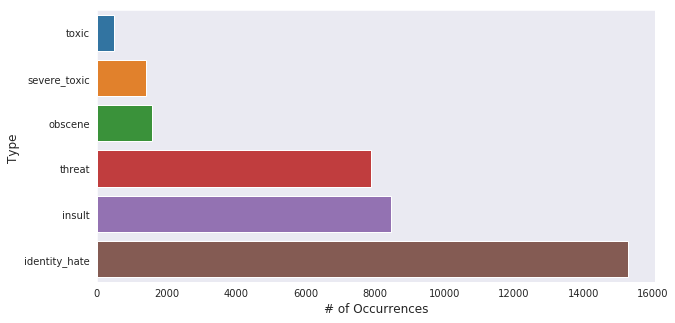

array([  478,  1405,  1595,  7877,  8449, 15294])

In [7]:
x=train.iloc[:,2:].sum()
x_values = np.sort(x.values)
#plot  
plt.figure(figsize=(10,5))
ax= sns.barplot( x_values, x.index, orient='h')
plt.xlabel('# of Occurrences', fontsize=12)
plt.ylabel('Type ', fontsize=12)

# rects = ax.patches
# labels = x.values
   
plt.show()
np.sort(x.values)

In [8]:
columns = list(x.index)
train.groupby(columns).size().sort_values(ascending=False).reset_index().rename(columns={0: 'count'}).head(15)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,count
0,0,0,0,0,0,0,143346
1,1,0,0,0,0,0,5666
2,1,0,1,0,1,0,3800
3,1,0,1,0,0,0,1758
4,1,0,0,0,1,0,1215
5,1,1,1,0,1,0,989
6,1,0,1,0,1,1,618
7,0,0,1,0,0,0,317
8,0,0,0,0,1,0,301
9,1,1,1,0,1,1,265


In [9]:
print("Out of {} rows: \n {} are toxic \n {}  are severe_toxic \n {}  are obscene \n {}   are threat \n {}  are insult and \n {}  are identity_hate". \
      format(len(train),len(train[train.toxic==1]),len(train[train.severe_toxic==1]),len(train[train.obscene==1]), \
             len(train[train.threat==1]),len(train[train.insult==1]),len(train[train.identity_hate==1])))

Out of 159571 rows: 
 15294 are toxic 
 1595  are severe_toxic 
 8449  are obscene 
 478   are threat 
 7877  are insult and 
 1405  are identity_hate


In [10]:
print("toxic examples:")
train[train['toxic']==1]['comment_text'][:5]

toxic examples:


6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
12    Hey... what is it..\n@ | talk .\nWhat is it......
16    Bye! \n\nDon't look, come or think of comming ...
42    You are gay or antisemmitian? \n\nArchangel WH...
43             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
Name: comment_text, dtype: object

In [11]:
print("severe_toxic examples:")
train[train['severe_toxic']==1]['comment_text'][:5]

severe_toxic examples:


6           COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
55     Stupid peace of shit stop deleting my stuff as...
181    you are a stupid fuck \n\nand your mother's cu...
442         Hi \n\nIm a fucking bitch.\n\n50.180.208.181
579    What a motherfucking piece of crap those fuckh...
Name: comment_text, dtype: object

In [12]:
print("obscene examples:")
train[train['obscene']==1]['comment_text'][:5]

obscene examples:


6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
42    You are gay or antisemmitian? \n\nArchangel WH...
43             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
51    GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK T...
55    Stupid peace of shit stop deleting my stuff as...
Name: comment_text, dtype: object

In [13]:
print("threatthreat examples:")
train[train['threat']==1]['comment_text'][:5]

threatthreat examples:


79      Hi! I am back again!\nLast warning!\nStop undo...
176     I think that your a Fagget get a oife and burn...
600     I'm also a sock puppet of this account...SUPRI...
802     Fuck you, Smith. Please have me notified when ...
1017    WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'L...
Name: comment_text, dtype: object

In [14]:
print("insult examples:")
train[train['insult']==1]['comment_text'][:5]

insult examples:


6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
42    You are gay or antisemmitian? \n\nArchangel WH...
43             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
55    Stupid peace of shit stop deleting my stuff as...
56    =Tony Sidaway is obviously a fistfuckee. He lo...
Name: comment_text, dtype: object

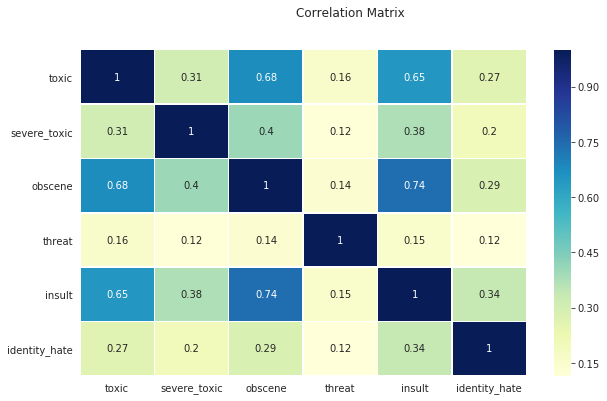

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train[columns].corr(), annot=True, cmap="YlGnBu", linewidths=.5, ax=ax);

**Comments length**

In [16]:
pd.set_option('display.max_colwidth', -1)

Fifth_line = train.comment_text.iloc[4]
Fifth_line,len(Fifth_line)

("You, sir, are my hero. Any chance you remember what page that's on?", 67)

In [17]:
train_length = train.comment_text.apply(len)
train_length.head(6)

0    264
1    112
2    233
3    622
4    67 
5    65 
Name: comment_text, dtype: int64

In [18]:
comments_max_ln  =np.max(train_length)
comments_min_ln  =np.min(train_length)
comments_mean_ln  =np.mean(train_length)
print (' comments_max_ln: {}, \n comments_min_ln: {} \n comments_mean_ln: {}'.format( comments_max_ln, 
                                                                                 comments_min_ln, comments_mean_ln ))

 comments_max_ln: 5000, 
 comments_min_ln: 6 
 comments_mean_ln: 394.0732213246768


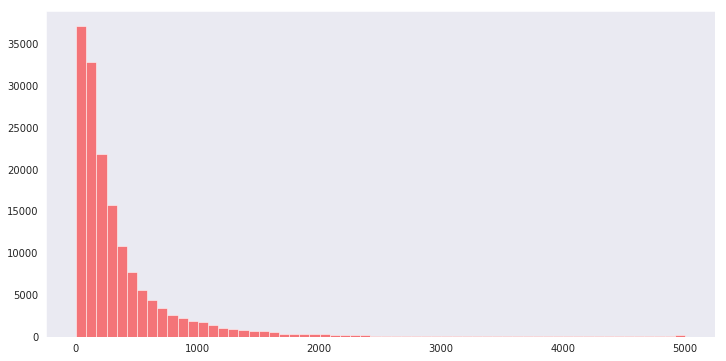

In [19]:
plt.figure(figsize = (12, 6))
plt.hist(train_length, bins = 60, alpha = 0.5, color = 'r')
plt.show()

In [20]:
print("max length : ", np.max(train_length))
print("min length : ", np.min(train_length))
print("mean length : ", np.mean(train_length))

max length :  5000
min length :  6
mean length :  394.0732213246768


In [21]:
'Check Missing Data'

def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        # written by MJ Bahmani
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)
    
check_missing_data(train)

False

In [22]:
print(train.comment_text.isna().sum())
print(test.comment_text.isna().sum())

0
0


In [23]:
test_comments = test.comment_text
test_comments[0:3]

0    Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,
1    == From RfC == \n\n The title is fine as it is, IMO.                                                                                                                                                                                                                                                                                                                           
2    " \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "                                                                                                                                                                                               

In [24]:
# list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# y = train[list_classes].values
y = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y[:5]

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

The approach that we are taking is to feed the comments into the LSTM as part of the neural network but we can't just feed the words as it is.

So this is what we are going to do:

1.     Tokenization - break down the sentence into words.
1.     Indexing - add token into dictionary and index them For eg, {1:"Natural",2:"language",3:"understading",4:"with",5:"deep_learning"}
1.     Index Representation- represent the sequence of tokens/words in the comments in the form of index, and feed this chain of index into our Long short-term memory (LSTM) . For eg, [1,2,3,4,2,5]

In [25]:
comments_train = train.comment_text
comments_test = test.comment_text
# create the tokenizer
tok = Tokenizer()
# fit the tokenizer on the documents
tok.fit_on_texts(list(comments_train))  # train.comment_text

num_words_count = len(tok.word_index) + 1  # 210338 +1
tokenizer_all_comments = Tokenizer(num_words=num_words_count)
tokenizer_all_comments.fit_on_texts(list(comments_train))

list_tokenized_train = tokenizer_all_comments.texts_to_sequences(comments_train)
list_tokenized_test = tokenizer_all_comments.texts_to_sequences(comments_test)

In [26]:
list_tokenized_test[:1]

[[2665,
  655,
  8849,
  656,
  8,
  57,
  16388,
  83,
  884,
  356,
  16,
  3222,
  76,
  21,
  6,
  4,
  6865,
  6,
  1521,
  7,
  56,
  655,
  4942,
  1898,
  682,
  6908,
  4,
  96,
  6,
  2,
  5104,
  29,
  417,
  6,
  726,
  39769,
  35,
  8849,
  656,
  8,
  36,
  4122,
  10,
  2818,
  660,
  437,
  454,
  19612,
  9,
  333,
  15,
  153,
  4,
  28513,
  8,
  240,
  30685,
  49,
  22636,
  52,
  24,
  5,
  2045,
  162,
  3132,
  682,
  2880,
  96,
  219,
  145,
  493,
  84]]

In [27]:
'to find max length of words in comments'
# distribution of number of words in sentence''
totalNumWords = [len(word_in_comment) for word_in_comment in list_tokenized_train]
totalNumWords.sort(reverse=True) # to find max word in list
totalNumWords[:5]

[1403, 1356, 1354, 1344, 1250]

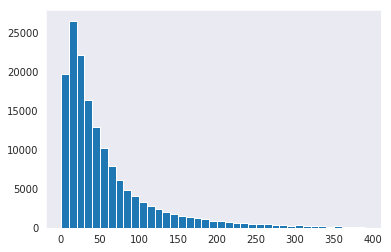

In [28]:
plt.hist(totalNumWords,bins = np.arange(0,400,10));

In [29]:
#  Most of the sentence length is about 30+. We could set the "maxlen" to about 50,
#  but I'm being paranoid so I have set to 200. 
max_len = 200
X_train = pad_sequences(list_tokenized_train, maxlen=max_len)
X_test = pad_sequences(list_tokenized_test, maxlen=max_len)

In [30]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

Embedding layer, project the words to a defined vector space depending on the distance of the surrounding words in a sentence. <br> 
Embedding allows us to reduce model size and most importantly the huge dimensions we have to deal with.

In [31]:
# By indicating an empty space after comma, we are telling Keras to infer the number automatically.
inp = Input(shape=(max_len, )) #maxlen=200 as defined earlier

In [32]:
embed_size = 128
layer = Embedding(num_words_count, embed_size)(inp);   # num_words_count = 210338 +1

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
# layer = LSTM(60, return_sequences=True,name='lstm_layer')(layer)
# layer = GlobalMaxPool1D()(layer)
# layer = Dropout(0.1)(layer)
# layer = Dense(50, activation="relu")(layer)
# layer = Dropout(0.1)(layer)
# layer = Dense(6, activation="sigmoid")(layer)
# model = Model(inputs = inp, outputs = layer)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# batch_size = 32
# epochs = 2
# model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [34]:
def model():
    embed_size = 128
    inp = Input(shape=(max_len, ))
    layer = Embedding(num_words_count, embed_size)(inp)
    layer = LSTM(60, return_sequences=True,name='lstm_layer')(layer)
#     layer = Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout = 0.15))(layer)
    layer = GlobalMaxPool1D()(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(50, activation="relu")(layer)
    layer = Dropout(0.1)(layer)
    layer = Dense(6, activation="sigmoid")(layer)
    model = Model(inputs = inp, outputs = layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
model = model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 128)          26923264  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
___________________________

In [36]:
file_path = 'save_analysis'
checkpoint = ModelCheckpoint(file_path, monitor = 'val_loss', verbose = 1, save_best_only=True)

early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)

In [37]:
hist = model.fit(X_train, y, batch_size = 32, epochs = 2, verbose=1, 
                 validation_split = 0.2, callbacks = [checkpoint, early_stop]);

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 127656 samples, validate on 31915 samples
Epoch 1/2
127656/127656 [==============================] - 1288s 10ms/step - loss: 0.0736 - acc: 0.9762 - val_loss: 0.0485 - val_acc: 0.9821

Epoch 00001: val_loss improved from inf to 0.04850, saving model to save_analysis
Epoch 2/2
127656/127656 [==============================] - 1286s 10ms/step - loss: 0.0420 - acc: 0.9839 - val_loss: 0.0468 - val_acc: 0.9825

Epoch 00002: val_loss improved from 0.04850 to 0.04678, saving model to save_analysis


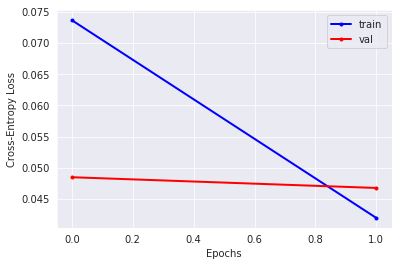

In [38]:
vloss = hist.history['val_loss']
loss = hist.history['loss']

#x_len = np.arange(len(loss))
#plt.plot(x_len, vloss, marker='.', lw=2.0, c='red', label='val')
#plt.plot(x_len, loss, marker='.', lw=2.0, c='blue', label='train')
plt.figure()
plt.plot(loss, marker='.', lw=2.0, c='blue', label='train')
plt.plot(vloss, marker='.', lw=2.0, c='red', label='val')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.grid()
plt.show()

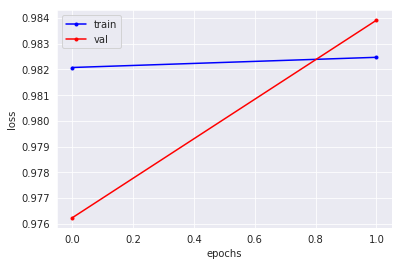

In [39]:
plt.figure()
plt.plot(hist.history['val_acc'], marker='.', c='blue', label='train')
plt.plot(hist.history['acc'], marker='.', c='red', label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [43]:
y_pred = model.predict(X_test)

In [44]:
submission = pd.read_csv('../input/sample_submission.csv')
list_classes=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"] 
submission[list_classes] = y_pred

submission.to_csv("submission.csv", index=False)

In [45]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.984290,1.406292e-01,0.861949,0.048773,0.825891,0.205311
1,0000247867823ef7,0.000258,1.192093e-07,0.000032,0.000009,0.000023,0.000007
2,00013b17ad220c46,0.001642,6.258488e-07,0.000250,0.000034,0.000134,0.000036
3,00017563c3f7919a,0.000139,0.000000e+00,0.000017,0.000001,0.000011,0.000004
4,00017695ad8997eb,0.000686,4.470348e-07,0.000086,0.000035,0.000067,0.000022
